# Cycle to Traffic Queue Simulation

Ever wondered how many cars are being taken off the road by people who cycle, wheel or scoot? So did we!

We could express this in terms of the number of cars, but we could also consider this in terms of length of queing traffic.

## Assumptions

Define some basic assumptions about traffic:

* **Vehicle Occupancy**: In the UK, average vehicle occupancy ranges from **1.2** people per car for commuting purposes, to **1.6** for shopping and leisure purposes. [[Source](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://assets.publishing.service.gov.uk/media/66ce0f6f25c035a11941f655/nts0905.ods)]  We'll assume that most private vehicles can accomodate up to 5 people.  We'll switch between average occupany based on the proportion of hours during typical commuting times (7am-9am and 4pm-6pm) vs leisure time with a ratio of 4:6, ie. 4 hours of commuting occupancy and 6 hours of leisure occupany.
* **Vehicle Length**: For the purposes of vehicle 'space', the defining characteristic is its length. For this comparison, vehicle width is unimportant.  In the UK, a variety of sources suggest that the average car length is 4.4m, ranging from 3.58m to 4.79m.
* **Vehicle separation length**: We'll assume that most cars, when stationary in traffic in city centre conditions, leave a gap of between 1 to 4m between their vehicles. The 'tires and tarmack' approach to vehicle spacing equates to approximatly 4m. An average separation of 2.5-3.5m is most likley based on some real world testing.

We'll also assume that people cycling, wheeling or scooting are likly to be doing so for the purposes of commuting and/or leisure, and unlikley to be doing so as part of their day-to-day job. For this reason, we'll not be simulating vans or lorries.

Finally, we'll assume that car occupancy, car size and vehicle spacing are all independent of each other.

## Approach

The basic approach is to simulate a range of vehicle occupancies, vehicle lengths and separation distances.  For a given cycle count, we find the equivalent number of vehicles transporting an equivalent number of people.  We then cumulatively sum the equivalent number of vehciles and separation distances to get out overall traffic queue.  Because the precise vechicle occupancy, vehicle lenght and vehicle separation distance is uncertain (within some defined ranges), we'll repeat the simulation 10,000 times (ie. Monte Carlo sampling) and calculate summary statistics (which will represent the uncertainty).

Visulisations of the assumed distribution (ie. 'priors') in vehicle occupancy, length and separation is shown below.

In [1]:
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import pytensor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pytensor.config.cxx = "/usr/bin/clang++"

In [ ]:
MEAN_OCCUPANCY_LEISURE = 1.6
MEAN_OCCUPANCY_COMMUTE = 1.2
CAR_LENGTH = 4.4
NJAMS = 10000

coords={'njams': list(range(NJAMS))}

with pm.Model(coords=coords) as model:
    # Define car occupancy
    occ_l = pm.Truncated.dist(dist=pm.Geometric.dist(p=1/MEAN_OCCUPANCY_LEISURE), lower=1, upper=5)
    occ_c = pm.Truncated.dist(dist=pm.Geometric.dist( p=1/MEAN_OCCUPANCY_COMMUTE), lower=1, upper=5)
    theta= pm.Bernoulli('theta', p=4/12, dims='njams')  # Switches between leisure and commuting
    theta_stacked = pt.stack([1-theta, theta], axis=1)
    car_occupancy = pm.Mixture('car_occupancy', w=theta_stacked , comp_dists=[occ_l, occ_c], dims='njams')
    idx_max = np.cumsum(car_occupancy)


    # Define car length
    car_length = pm.TruncatedNormal('car_length', mu=CAR_LENGTH, sigma=0.5, lower=3.6, upper=4.8, dims='njams')

    # Vehicle separation
    car_separation = pm.TruncatedNormal('car_separation', mu=2.5, sigma=1, lower=1, upper=4, dims='njams')

    # Traffic length
    traffic_length = car_length+car_separation
    model.register_rv(traffic_length, name="traffic_length", dims='njams')
    idata = pm.sample_prior_predictive(draws=1000)

Sampling: [car_length, car_occupancy, car_separation, theta, traffic_length]


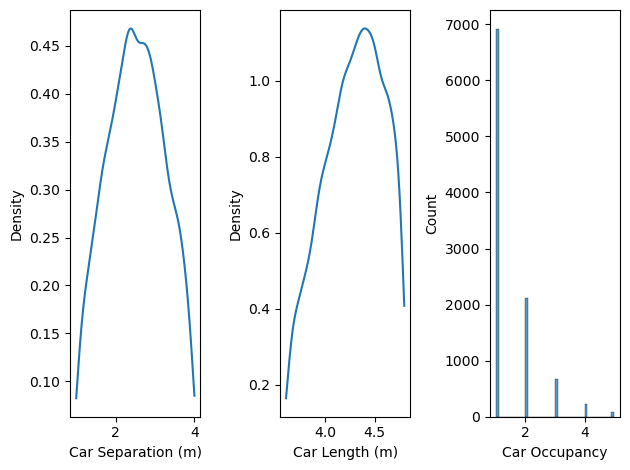

In [ ]:
# Visulise an example set of prior distributions
plt.subplot(131)
plt.xlabel("Car Separation (m)")
sns.kdeplot(idata.prior['car_separation'][0,0,:], clip=[1, 4])
plt.subplot(132)
plt.xlabel("Car Length (m)")
sns.kdeplot(idata.prior['car_length'][0,0,:], clip=[3.6, 4.8])
plt.subplot(133)
plt.xlabel("Car Occupancy")
sns.histplot(idata.prior['car_occupancy'][0,0,:])
plt.tight_layout()

## Results

Find the car index (`TL_IDX`) which corresponds to the `NPAX` (number of transported people), then calculate the accumulated sum of car up to that point (to give `jam_length`).

In this case we take NPAX from the average cycle count (analysed in `24hr-analysis.ipynb`) at a few key locations.

We also calculate the uncertainty in total traffic length given variations in car length, car separation and vehicle occupancy based on summarising across `NJAMS`.

Remeber, these traffic queue figures are **daily equivalent traffic queues**, ie. length of traffic saved _each day_.

In [ ]:
# Pick specific location and their average counts
LOC_COUNTS = {"Exeter Road": 360,
              "Haven Banks": 980,
              "Riverside Valley Park": 940,
              "Exminster Canal Causeway": 394,
              "Vaughan Road": 329}

# Loop over each location
for LOC, NPAX in LOC_COUNTS.items():
    TL_IDX = abs(idata.prior['car_occupancy'].cumsum(dim=['draw'])-NPAX).argmin(dim='draw')
    jam_length = idata.prior['traffic_length'].cumsum(dim=['draw']).isel(draw=TL_IDX).quantile(q=[0.1, 0.5, 0.9])
    # Print summary
    print(f"{LOC}: {(jam_length[1].data/1000)*0.621371:.1f} miles [{(jam_length[0].data/1000)*0.621371:.2f} to {(jam_length[2].data/1000)*0.621371:.2f}]")

Exeter Road: 1.1 miles [1.00 to 1.10]
Haven Banks: 2.9 miles [2.79 to 2.94]
Riverside Valley Park: 2.7 miles [2.67 to 2.82]
Exminster Canal Causeway: 1.2 miles [1.10 to 1.20]
Vaughan Road: 1.0 miles [0.91 to 1.01]
